In [1]:
import pandas as pd
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

C:\Users\wxhxbt\Anaconda3\envs\tf11\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wxhxbt\Anaconda3\envs\tf11\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wxhxbt\Anaconda3\envs\tf11\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\wxhxbt\Anaconda3\envs\tf11\lib\site-packages\tensorflow\python\f

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib
from bert_serving.client import BertClient

In [5]:
# bc = BertClient(ip='192.168.86.41')
# bc.encode(['First do it', 'then do it right', 'then do it better'])

# Data Loading

In [6]:
def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [7]:
data_dir = './'
download_extract('ml-1m', data_dir)

Extracting ml-1m...
Done.


In [3]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# Data Preprocessing

In [23]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)
    
    # Get the extracted movie title feature from bert
    if os.path.exists("bert_encoded_title.p"):
        movies['Title'] = pickle.load(open('bert_encoded_title.p', mode='rb'))
    else:
        bc = BertClient()
        title_map = {val:bc.encode([val])[0] for ii,val in enumerate(set(movies['Title']))}
        movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [24]:
# pickle.dump(movies['Title'], open('bert_encoded_title.p', 'wb'))
genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess2.p', 'wb'))

In [6]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [22]:
movies.head()

,MovieID,Title,Genres
0,1,"[-0.5726612, -0.3172742, -0.20371202, -0.20670...","[17, 0, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."
1,2,"[-0.36613265, -0.865088, -0.26034635, -0.24028...","[18, 0, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."
2,3,"[-0.3607318, 0.0059039528, 0.066141166, 0.0151...","[6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
3,4,"[0.40832582, -0.1697424, 0.13474943, -0.193436...","[6, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
4,5,"[-0.42645, -0.5103114, 0.21123752, -0.30739355...","[6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


In [8]:
data.head()

,UserID,MovieID,ratings,Gender,Age,JobID,Title,Genres
0,1,1193,5,0,0,10,"[-0.038056023, 0.23439522, -0.35930735, -0.099...","[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
1,2,1193,5,1,5,16,"[-0.038056023, 0.23439522, -0.35930735, -0.099...","[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
2,12,1193,4,1,6,12,"[-0.038056023, 0.23439522, -0.35930735, -0.099...","[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
3,15,1193,4,1,6,7,"[-0.038056023, 0.23439522, -0.35930735, -0.099...","[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
4,17,1193,5,1,3,1,"[-0.038056023, 0.23439522, -0.35930735, -0.099...","[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


In [9]:
features[0]

array([1, 1193, 0, 0, 10,
       array([-3.80560234e-02,  2.34395221e-01, -3.59307349e-01, -9.91238579e-02,
        3.66178542e-01, -3.60790268e-02, -3.86045098e-01,  5.24232209e-01,
       -7.15995848e-01,  2.62239516e-01,  4.61214483e-01, -6.93597555e-01,
       -1.28532618e-01,  1.35980338e-01, -7.29559779e-01,  2.81656832e-01,
       -1.19447216e-01,  1.53474420e-01,  3.53073210e-01, -2.35526860e-02,
       -2.17893720e-01,  2.61140764e-01, -7.88218081e-01, -6.02616549e-01,
        3.94233316e-01,  1.17122039e-01, -3.51624675e-02,  1.71095893e-01,
       -6.76342705e-03,  7.52976313e-02, -1.88600451e-01,  7.39003658e-01,
        5.34284711e-01, -1.55626252e-01, -7.20756710e-01, -2.04829603e-01,
        6.61011040e-02, -2.02436328e-01, -7.01153636e-01, -3.23604494e-01,
       -1.34631082e-01, -7.16558993e-01,  4.57473665e-01, -3.55783641e-01,
        4.04813439e-01,  1.76159069e-01, -3.78521055e-01,  1.83217019e-01,
        3.60047311e-01, -2.58149415e-01, -1.87774494e-01,  6.079440

In [10]:
targets_values

array([[5],
       [5],
       [4],
       ...,
       [1],
       [5],
       [4]], dtype=int64)

In [3]:
genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess2.p', mode='rb'))

In [5]:
def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params2.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params2.p', mode='rb'))

In [9]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
# movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
# sentences_size = title_count # = 15
sentences_size = movies.Title.iloc[0].shape[0] # 768
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}
idx2movieid = {i:val[0] for i, val in enumerate(movies.values)}

In [10]:
train_data, test_data, train_targets, test_targets = train_test_split(features, targets_values, test_size = 0.2, random_state = 0)

In [11]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save2/'

In [15]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
#     movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    movie_titles = tf.placeholder(tf.float32, [None, 768], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [16]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [17]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [18]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [19]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

In [20]:
def get_movie_bert_layer(movie_titles):
    with tf.name_scope("movie_title_fc"):
        movie_title_fc_layer = tf.layers.dense(movie_titles, embed_dim, name = "movie_title_fc_layer", activation=tf.nn.relu)
        movie_title_fc_layer_flat = tf.reshape(movie_title_fc_layer, [-1, 1, embed_dim])
    return movie_title_fc_layer_flat

def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, movie_title_fc_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, movie_title_fc_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [21]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    movie_title_fc_layer = get_movie_bert_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                movie_title_fc_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [23]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [24]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph, config=config) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #cross validation
#         train_X,test_X, train_y, test_y = train_test_split(features,  
#                                                            targets_values,  
#                                                            test_size = 0.2,  
#                                                            random_state = 0)
        train_X,test_X, train_y, test_y = train_test_split(train_data,  
                                                           train_targets,  
                                                           test_size = 0.1,  
                                                           random_state = None) 
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]
            
            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}
            
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to C:\Users\wxhxbt\jupyter\MovieRec\runs\1619149982

2021-04-22T23:53:04.074266: Epoch   0 Batch    0/2813   train_loss = 36.327
2021-04-22T23:53:04.496031: Epoch   0 Batch   20/2813   train_loss = 5.823
2021-04-22T23:53:04.912792: Epoch   0 Batch   40/2813   train_loss = 3.465
2021-04-22T23:53:05.335515: Epoch   0 Batch   60/2813   train_loss = 2.787
2021-04-22T23:53:05.774813: Epoch   0 Batch   80/2813   train_loss = 2.224
2021-04-22T23:53:06.209578: Epoch   0 Batch  100/2813   train_loss = 1.858
2021-04-22T23:53:06.636332: Epoch   0 Batch  120/2813   train_loss = 1.890
2021-04-22T23:53:07.078077: Epoch   0 Batch  140/2813   train_loss = 1.745
2021-04-22T23:53:07.516810: Epoch   0 Batch  160/2813   train_loss = 1.875
2021-04-22T23:53:07.942746: Epoch   0 Batch  180/2813   train_loss = 2.021
2021-04-22T23:53:08.361488: Epoch   0 Batch  200/2813   train_loss = 1.478
2021-04-22T23:53:08.785258: Epoch   0 Batch  220/2813   train_loss = 1.973
2021-04-22T23:53:09.214011: Epoch   0 

2021-04-22T23:53:50.548954: Epoch   0 Batch 2180/2813   train_loss = 1.101
2021-04-22T23:53:50.977718: Epoch   0 Batch 2200/2813   train_loss = 1.121
2021-04-22T23:53:51.402478: Epoch   0 Batch 2220/2813   train_loss = 1.216
2021-04-22T23:53:51.823231: Epoch   0 Batch 2240/2813   train_loss = 1.178
2021-04-22T23:53:52.243992: Epoch   0 Batch 2260/2813   train_loss = 1.158
2021-04-22T23:53:52.668743: Epoch   0 Batch 2280/2813   train_loss = 1.220
2021-04-22T23:53:53.109480: Epoch   0 Batch 2300/2813   train_loss = 1.048
2021-04-22T23:53:53.539234: Epoch   0 Batch 2320/2813   train_loss = 0.989
2021-04-22T23:53:53.996970: Epoch   0 Batch 2340/2813   train_loss = 1.150
2021-04-22T23:53:54.420544: Epoch   0 Batch 2360/2813   train_loss = 0.954
2021-04-22T23:53:54.845290: Epoch   0 Batch 2380/2813   train_loss = 0.954
2021-04-22T23:53:55.291042: Epoch   0 Batch 2400/2813   train_loss = 1.175
2021-04-22T23:53:55.716801: Epoch   0 Batch 2420/2813   train_loss = 1.205
2021-04-22T23:53:56.15053

2021-04-22T23:54:38.282376: Epoch   1 Batch 1247/2813   train_loss = 0.903
2021-04-22T23:54:38.708135: Epoch   1 Batch 1267/2813   train_loss = 0.942
2021-04-22T23:54:39.138887: Epoch   1 Batch 1287/2813   train_loss = 0.919
2021-04-22T23:54:39.568640: Epoch   1 Batch 1307/2813   train_loss = 0.997
2021-04-22T23:54:39.997380: Epoch   1 Batch 1327/2813   train_loss = 1.202
2021-04-22T23:54:40.426132: Epoch   1 Batch 1347/2813   train_loss = 0.917
2021-04-22T23:54:40.848888: Epoch   1 Batch 1367/2813   train_loss = 1.228
2021-04-22T23:54:41.275642: Epoch   1 Batch 1387/2813   train_loss = 0.980
2021-04-22T23:54:41.705400: Epoch   1 Batch 1407/2813   train_loss = 1.107
2021-04-22T23:54:42.128162: Epoch   1 Batch 1427/2813   train_loss = 0.993
2021-04-22T23:54:42.557918: Epoch   1 Batch 1447/2813   train_loss = 0.957
2021-04-22T23:54:42.990655: Epoch   1 Batch 1467/2813   train_loss = 1.030
2021-04-22T23:54:43.859159: Epoch   1 Batch 1487/2813   train_loss = 0.905
2021-04-22T23:54:45.01750

2021-04-22T23:55:34.009993: Epoch   2 Batch  314/2813   train_loss = 0.958
2021-04-22T23:55:34.435763: Epoch   2 Batch  334/2813   train_loss = 0.886
2021-04-22T23:55:34.856507: Epoch   2 Batch  354/2813   train_loss = 1.100
2021-04-22T23:55:35.277278: Epoch   2 Batch  374/2813   train_loss = 1.008
2021-04-22T23:55:35.699035: Epoch   2 Batch  394/2813   train_loss = 0.973
2021-04-22T23:55:36.122777: Epoch   2 Batch  414/2813   train_loss = 0.939
2021-04-22T23:55:36.555528: Epoch   2 Batch  434/2813   train_loss = 0.949
2021-04-22T23:55:36.983221: Epoch   2 Batch  454/2813   train_loss = 0.952
2021-04-22T23:55:37.418978: Epoch   2 Batch  474/2813   train_loss = 0.970
2021-04-22T23:55:37.843725: Epoch   2 Batch  494/2813   train_loss = 0.876
2021-04-22T23:55:39.152971: Epoch   2 Batch  514/2813   train_loss = 0.975
2021-04-22T23:55:39.851567: Epoch   2 Batch  534/2813   train_loss = 1.154
2021-04-22T23:55:40.266329: Epoch   2 Batch  554/2813   train_loss = 0.924
2021-04-22T23:55:40.68809

2021-04-22T23:56:37.347912: Epoch   2 Batch 2514/2813   train_loss = 0.939
2021-04-22T23:56:38.511242: Epoch   2 Batch 2534/2813   train_loss = 1.067
2021-04-22T23:56:39.360753: Epoch   2 Batch 2554/2813   train_loss = 0.801
2021-04-22T23:56:39.777518: Epoch   2 Batch 2574/2813   train_loss = 0.839
2021-04-22T23:56:40.201261: Epoch   2 Batch 2594/2813   train_loss = 0.831
2021-04-22T23:56:40.626328: Epoch   2 Batch 2614/2813   train_loss = 0.903
2021-04-22T23:56:42.120459: Epoch   2 Batch 2634/2813   train_loss = 0.913
2021-04-22T23:56:42.661156: Epoch   2 Batch 2654/2813   train_loss = 0.926
2021-04-22T23:56:43.108890: Epoch   2 Batch 2674/2813   train_loss = 0.818
2021-04-22T23:56:43.561627: Epoch   2 Batch 2694/2813   train_loss = 1.006
2021-04-22T23:56:44.532073: Epoch   2 Batch 2714/2813   train_loss = 0.899
2021-04-22T23:56:45.652426: Epoch   2 Batch 2734/2813   train_loss = 0.864
2021-04-22T23:56:46.114159: Epoch   2 Batch 2754/2813   train_loss = 0.941
2021-04-22T23:56:46.56790

2021-04-22T23:57:42.170422: Epoch   3 Batch 1601/2813   train_loss = 0.810
2021-04-22T23:57:43.757459: Epoch   3 Batch 1621/2813   train_loss = 0.848
2021-04-22T23:57:44.191494: Epoch   3 Batch 1641/2813   train_loss = 0.916
2021-04-22T23:57:44.612236: Epoch   3 Batch 1661/2813   train_loss = 0.899
2021-04-22T23:57:45.033994: Epoch   3 Batch 1681/2813   train_loss = 1.164
2021-04-22T23:57:45.873514: Epoch   3 Batch 1701/2813   train_loss = 0.960
2021-04-22T23:57:47.051763: Epoch   3 Batch 1721/2813   train_loss = 1.003
2021-04-22T23:57:47.477516: Epoch   3 Batch 1741/2813   train_loss = 1.046
2021-04-22T23:57:47.897264: Epoch   3 Batch 1761/2813   train_loss = 0.974
2021-04-22T23:57:48.324029: Epoch   3 Batch 1781/2813   train_loss = 0.869
2021-04-22T23:57:49.502343: Epoch   3 Batch 1801/2813   train_loss = 0.878
2021-04-22T23:57:50.345248: Epoch   3 Batch 1821/2813   train_loss = 0.786
2021-04-22T23:57:50.773000: Epoch   3 Batch 1841/2813   train_loss = 0.955
2021-04-22T23:57:51.19875

2021-04-22T23:58:45.957770: Epoch   4 Batch  668/2813   train_loss = 0.706
2021-04-22T23:58:46.381512: Epoch   4 Batch  688/2813   train_loss = 0.895
2021-04-22T23:58:46.810561: Epoch   4 Batch  708/2813   train_loss = 0.950
2021-04-22T23:58:48.300711: Epoch   4 Batch  728/2813   train_loss = 0.871
2021-04-22T23:58:48.822718: Epoch   4 Batch  748/2813   train_loss = 0.969
2021-04-22T23:58:49.242475: Epoch   4 Batch  768/2813   train_loss = 0.963
2021-04-22T23:58:49.663233: Epoch   4 Batch  788/2813   train_loss = 0.826
2021-04-22T23:58:50.311847: Epoch   4 Batch  808/2813   train_loss = 0.961
2021-04-22T23:58:51.683724: Epoch   4 Batch  828/2813   train_loss = 0.844
2021-04-22T23:58:52.098485: Epoch   4 Batch  848/2813   train_loss = 0.823
2021-04-22T23:58:52.531472: Epoch   4 Batch  868/2813   train_loss = 0.895
2021-04-22T23:58:52.955224: Epoch   4 Batch  888/2813   train_loss = 0.851
2021-04-22T23:58:53.972630: Epoch   4 Batch  908/2813   train_loss = 0.881
2021-04-22T23:58:54.97306

2021-04-22T23:59:56.894172: Epoch   4 Batch   52/312   test_loss = 0.900
2021-04-22T23:59:57.059078: Epoch   4 Batch   72/312   test_loss = 0.910
2021-04-22T23:59:57.225610: Epoch   4 Batch   92/312   test_loss = 0.797
2021-04-22T23:59:57.388507: Epoch   4 Batch  112/312   test_loss = 0.895
2021-04-22T23:59:57.556410: Epoch   4 Batch  132/312   test_loss = 0.759
2021-04-22T23:59:57.721313: Epoch   4 Batch  152/312   test_loss = 0.883
2021-04-22T23:59:57.886219: Epoch   4 Batch  172/312   test_loss = 0.921
2021-04-22T23:59:58.053125: Epoch   4 Batch  192/312   test_loss = 0.889
2021-04-22T23:59:58.220027: Epoch   4 Batch  212/312   test_loss = 0.791
2021-04-22T23:59:58.385932: Epoch   4 Batch  232/312   test_loss = 0.840
2021-04-22T23:59:58.555833: Epoch   4 Batch  252/312   test_loss = 0.823
2021-04-22T23:59:58.739737: Epoch   4 Batch  272/312   test_loss = 0.930
2021-04-22T23:59:58.905646: Epoch   4 Batch  292/312   test_loss = 0.746
Model Trained and Saved


In [25]:
# load_dir
# !rm -rf ml-1m
min(losses['train']), min(losses['test'])

(0.60521394, 0.61942226)

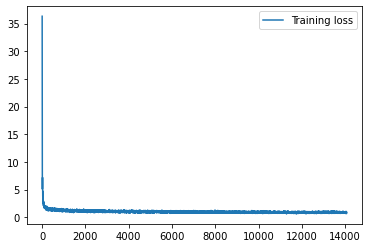

In [26]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

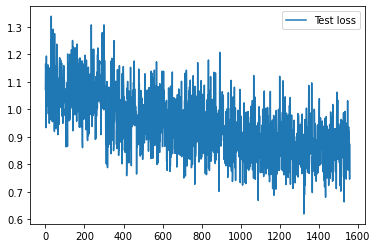

In [27]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

In [28]:
save_params((save_dir))

In [6]:
load_dir = load_params()

In [30]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 这里也要修改 感谢网友 @清歌 指出问题
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

In [31]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
    return (inference_val)

In [32]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save2/


[array([[3.4785843]], dtype=float32)]

In [33]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save2/


In [7]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))
movie_matrics.shape

(3883, 200)

In [35]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save2/


In [8]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))
users_matrics.shape

(6040, 200)

In [37]:
def evaluate_model():
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        predict_rating = []
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)

        for i in tqdm(range(test_data.shape[0])):
            categories = np.zeros([1, 18])
            categories[0] = test_data[i][6]

            titles = np.zeros([1, sentences_size])
            titles[0] = test_data[i][5]

            feed = {
                uid: np.reshape(test_data[i][0], [1, 1]),
                user_gender: np.reshape(test_data[i][2], [1, 1]),
                user_age: np.reshape(test_data[i][3], [1, 1]),
                user_job: np.reshape(test_data[i][4], [1, 1]),
                movie_id: np.reshape(test_data[i][1], [1, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(test_targets[i], [1, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}

            inference_val = sess.run([inference], feed)
            predict_rating.append(inference_val)
        return predict_rating
    
predict_rating = evaluate_model()

INFO:tensorflow:Restoring parameters from ./save2/


100%|█████████████████████████████████████████████████████████████████████████| 200042/200042 [16:57<00:00, 196.60it/s]


In [44]:
pickle.dump((np.squeeze(np.array(predict_rating))), open('eva_ratings.p', 'wb'))
predict_rating = pickle.load(open('eva_ratings.p', mode='rb'))

In [13]:
predict_rating = pickle.load(open('eva_ratings.p', mode='rb'))
print(f"Accuracy: {round((test_targets.squeeze() == np.round(predict_rating, 0).astype(int)).sum() * 100 / predict_rating.shape[0], 2)}%")
# print(f"Acc V2: {round((np.abs(test_targets.squeeze() - predict_rating) < 1).sum() * 100 / predict_rating.shape[0], 2)}%")

Accuracy: 41.29%


In [14]:
def get_rating_matrix(users_matrics, movie_matrics):
    rating_mat = np.matmul(users_matrics, np.transpose(movie_matrics))
    ######################important##################################
    usr_id, mov_id = test_data[2][0], test_data[2][1]
    print(rating_mat[usr_id-1, movieid2idx[mov_id]], predict_rating[2])
    return rating_mat

rating_mat = get_rating_matrix(users_matrics, movie_matrics)

3.5959795 3.5959795


In [15]:
rating_mat.shape

(6040, 3883)

In [16]:
def compute_precision():
    # Only runs in test dataset
    columns=['U_ID', 'M_ID', 'U_Gender', 'U_Age', 'U_Job', 'M_Title', 'M_Genre']
    test_df = pd.DataFrame(test_data[:, :2], columns=['U_ID', 'M_ID'])
    test_df['Rating'] = test_targets
    test_df['Predict_Rating'] = predict_rating
    
    positive_df = test_df[test_df['Rating'] > 3]
    precision = (positive_df['Predict_Rating'] > 3).sum() / (test_df['Predict_Rating'].round(0) > 3).sum()
    recall = (positive_df['Predict_Rating'] > 3).sum() / positive_df.shape[0]
    print('Precision: {:0.2f}%\nRecall: {:0.2f}%'.format(precision*100, recall*100))
    return precision, recall

pre, rec = compute_precision()

Precision: 88.42%
Recall: 95.09%


In [18]:
def compute_precision_v2(rank=20):
    rate_table = ratings.copy()
    rate_table['Predict_Rating'] = rate_table.apply(lambda x: rating_mat[x.UserID-1, movieid2idx[x.MovieID]], axis=1)

    cnt = 0
    gb = rate_table.groupby('UserID')
    for k in gb.groups.keys():
        group = gb.get_group(k).copy()
        group.sort_values(by=['Predict_Rating'], ascending=False, inplace=True)
        group = group.iloc[:rank]
        cnt += (group['ratings'] > 3).sum()
        
    precision = cnt / (len(users) * rank)
    recall = cnt / (rate_table['ratings'] > 3).sum()
    user_median_num_rate = rate_table.groupby('UserID').agg({'MovieID':'count'}).median()[0]
    recall_rebalance = recall * user_median_num_rate / rank
    print('Precision: {:0.2f}%\nRecall: {:0.2f}%'.format(precision*100, recall_rebalance*100))
    return precision, recall_rebalance, rate_table

pre, rec, comb_pre_ratings = compute_precision_v2(rank=20)

Precision: 80.85%
Recall: 81.49%


In [294]:
comb_pre_ratings.head()

,UserID,MovieID,ratings,Predict_Rating
0,1,1193,5,4.420122
1,1,661,3,3.611515
2,1,914,3,4.466289
3,1,3408,4,4.265350
4,1,2355,5,3.997452


In [319]:
user_median_num_rate = comb_pre_ratings.groupby('UserID').agg({'MovieID':'count'}).median()[0]
print(int(user_median_num_rate))

96


In [169]:
# positive_ratings = ratings[ratings['ratings'] > 3].copy()

# positive_ratings['Hash'] = (positive_ratings['UserID'] - 1).astype(str) + ',' + positive_ratings['MovieID'].map(movieid2idx).astype(str)

# positive_ratings.head()

# sorted_id = (-rating_mat).argsort(axis=1)
# print(np.take_along_axis(rating_mat, sorted_id, axis=1))

# sorted_id = sorted_id[:, :10]

# cnt = 0
# p_rating_arr = positive_ratings.Hash.values
# for i in tqdm(range(sorted_id.shape[0])):
#     for j in range(sorted_id.shape[1]):
#         cor = str(i)+','+str(sorted_id[i, j])
#         if cor in p_rating_arr:
#             cnt += 1
# print(cnt)

In [55]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [56]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save2/
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
1380
[1401 'Ghosts of Mississippi (1996)' 'Drama']
3796
[3866 'Sunset Strip (2000)' 'Comedy']
340
[344 'Ace Ventura: Pet Detective (1994)' 'Comedy']
1048
[1062 'Sunchaser, The (1996)' 'Drama']
479
[483 'King of the Hill (1993)' 'Drama']


{340, 479, 1048, 1380, 3796}

In [57]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results

In [58]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save2/
以下是给您的推荐：
257
[260 'Star Wars: Episode IV - A New Hope (1977)'
 'Action|Adventure|Fantasy|Sci-Fi']
574
[578 'Hour of the Pig, The (1993)' 'Drama|Mystery']
1961
[2030 'East Palace West Palace (Dong gong xi gong) (1997)' 'Drama']
3448
[3517 'Bells, The (1926)' 'Crime|Drama']
1950
[2019
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{257, 574, 1950, 1961, 3448}

In [59]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 3:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [60]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save2/
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[1958 'F' 25 1]
 [1805 'M' 18 4]
 [52 'M' 18 4]
 [2608 'F' 25 1]
 [4504 'F' 25 0]
 [4249 'F' 18 17]
 [3754 'M' 56 7]
 [1590 'M' 35 1]
 [2082 'M' 1 19]
 [1131 'M' 56 13]
 [4085 'F' 25 6]
 [5458 'F' 18 2]
 [1081 'M' 18 4]
 [5567 'M' 50 3]
 [100 'M' 35 17]
 [5669 'M' 56 1]
 [2737 'M' 25 3]
 [4800 'M' 18 4]
 [2154 'M' 25 12]
 [1763 'M' 35 7]]
喜欢看这个电影的人还喜欢看：
1961
[2030 'East Palace West Palace (Dong gong xi gong) (1997)' 'Drama']
1435
[1462 'Unforgotten: Twenty-Five Years After Willowbrook (1996)'
 'Documentary']
574
[578 'Hour of the Pig, The (1993)' 'Drama|Mystery']


{574, 1435, 1961}

# Test

In [61]:
# bc = BertClient()
# bc.encode(['First do it'])

In [62]:
movies.Title.iloc[0].shape[0]

768

In [108]:
# users

In [64]:
# x = tf.convert_to_tensor(movies.Title.iloc[0], np.float32)
# x = tf.reshape(x, [1, -1])
# x.dtype

# # a = tf.layers.dense(x, 32, name = "movie_title_fc_layer", activation=tf.nn.relu)
# # a.get_shape()